In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [486]:
%%time
df = pd.read_excel('nyc_benchmarking_disclosure_2017_consumption_data.xlsx',
            'Information and Metrics', usecols='P, S, T, AA, AE, AG, AL, AL:AN, AQ, AT, AV, AW, BA:BC, BD, BE')

CPU times: total: 11 s
Wall time: 11.6 s


In [499]:
frames = list()
names = list()
notIncluded = ['Largest Property Use Type', 'Electricity Use', 'Electricity Use - Grid Purchase (kWh)',
               'Total GHG Emissions (Metric Tons CO2e)', 'Direct GHG Emissions (Metric Tons CO2e)',
               'Indirect GHG Emissions (Metric Tons CO2e)']
for c in df.columns:
    if c in notIncluded:
        continue
    frames.append(df[c].fillna(0))
    names.append(c)
dfx = pd.concat(frames, axis=1)
x = np.array(dfx[names])
yEl = np.array(df['Electricity Use'].fillna(0)).reshape(-1, 1)
yEm = np.array(df['Total GHG Emissions (Metric Tons CO2e)'].fillna(0)).reshape(-1, 1)

In [500]:
regEm = LinearRegression().fit(x, yEm)
regEl = LinearRegression().fit(x, yEl)

In [501]:
df

,Self-Reported Gross Floor Area (ft²),Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Occupancy,Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),Fuel Oil 2 Use,Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Electricity Use,Electricity Use - Grid Purchase (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²)
0,169416,Office,164754.0,95,138.4,53.8,NaN,NaN,NaN,1133475.1,1435754.7,6551394.1,1920103.6,732.4,76.3,656.1,3635.5,21.46
1,94380,K-12 School,94380.0,100,43.5,28.4,NaN,NaN,NaN,NaN,2068300.1,616343.7,180640.0,164.5,109.9,54.6,102.9,1.09
2,125000,Hotel,125000.0,85,271.1,130.2,NaN,NaN,NaN,NaN,8245445.1,8033914.4,2354605.3,1150.2,438.0,712.3,10762.6,86.10
3,50000,Hotel,50000.0,100,163.0,76.5,NaN,NaN,NaN,NaN,1848519.4,1976691.9,579335.2,273.4,98.2,175.3,790.1,15.80
4,50000,Hotel,50000.0,0,64.2,20.5,NaN,NaN,NaN,NaN,NaN,1022951.6,299809.9,90.7,0.0,90.7,143.0,2.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34350,32800,Multifamily Housing,32800.0,100,123.6,101.6,NaN,NaN,NaN,NaN,3017000.3,316524.4,92768.0,187.1,160.2,26.8,295851.5,9019.86
34351,32350,Multifamily Housing,32350.0,100,120.4,100.4,NaN,NaN,NaN,NaN,2969100.0,277672.0,81381.0,181.2,157.7,23.5,283262.5,8756.18
34352,33800,Multifamily Housing,33800.0,100,155.7,117.2,NaN,NaN,NaN,NaN,3333200.0,629677.8,184548.0,230.4,177.0,53.3,451795.0,13366.71
34353,263259,Multifamily Housing,217259.0,100,75.9,28.1,NaN,NaN,NaN,NaN,394383.3,6979300.9,2045515.8,614.8,23.7,591.1,7118.2,27.04


In [541]:
record = list()
outlierCounter = 0
for index in range(34355):
    vals = list(df.iloc[index].fillna(0))
    prediction = np.array([vals[0]] + vals[2:11] + vals[16:]).reshape(1, -1)

    predEm = regEm.predict(prediction)[0][0]
    
    if np.isnan(df.iloc[index][13]):
        continue

#     print(df.iloc[index])
#     print()
#     print('PREDICTED GHG EMISSIONS:', predEm)
#     print('ACTUAL GHG EMISSIONS:', round(df.iloc[index][13]))
    if df.iloc[index][13] == 0:
        continue
        
#     print('ABS PERCENT ERROR:', abs(round((predEm - df.iloc[index][13]) / df.iloc[index][13] * 100)), '%')
    
    if (predEm - df.iloc[index][13]) / df.iloc[index][13] * 100 > 100:
#         print((predEm - df.iloc[index][13]) / df.iloc[index][13] * 100, 'OUTLIER')
        outlierCounter += 1
        continue
    
    record.append((predEm - df.iloc[index][13]) / df.iloc[index][13] * 100)

print(sum(record) / len(record))
print(outlierCounter)

6.040441505602117
1884


(0.0, 50000.0)

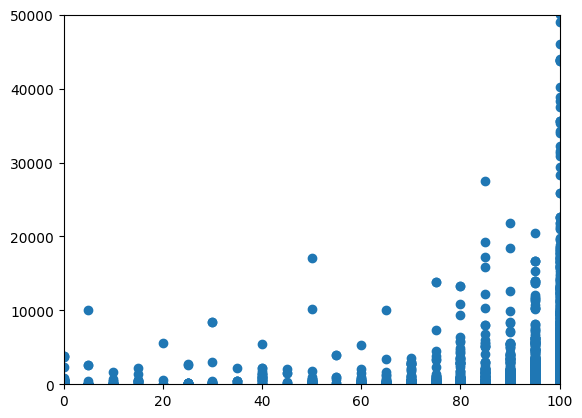

In [503]:
p = plt.scatter(df['Occupancy'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 100)
plt.ylim(0, 50000)

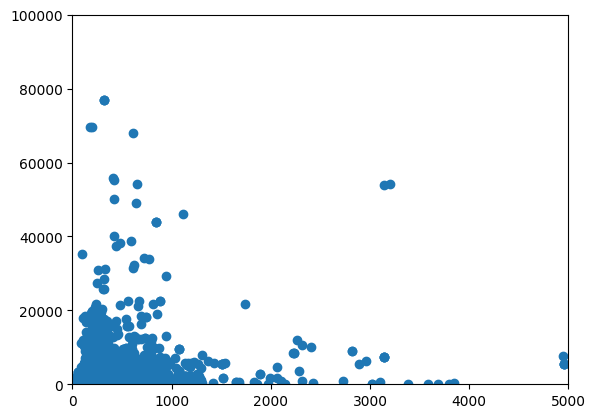

In [504]:
p = plt.scatter(df['Source EUI (kBtu/ft²)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 5000)
plt.ylim(0, 100000)
plt.show()

(0.0, 100000.0)

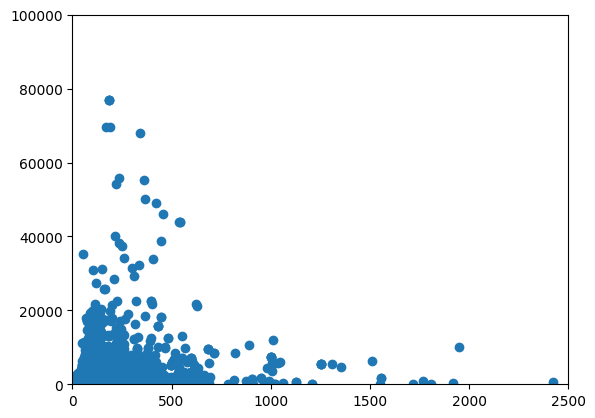

In [505]:
p = plt.scatter(df['Site EUI (kBtu/ft²)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 2500)
plt.ylim(0, 100000)

(0.0, 10000.0)

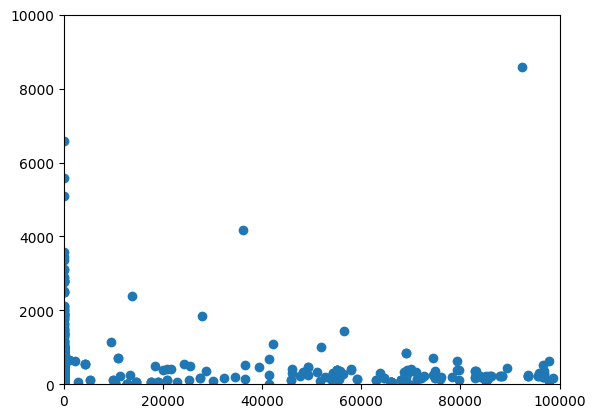

In [506]:
p = plt.scatter(df['Fuel Oil 2 Use'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 100000)
plt.ylim(0, 10000)

(0.0, 5000.0)

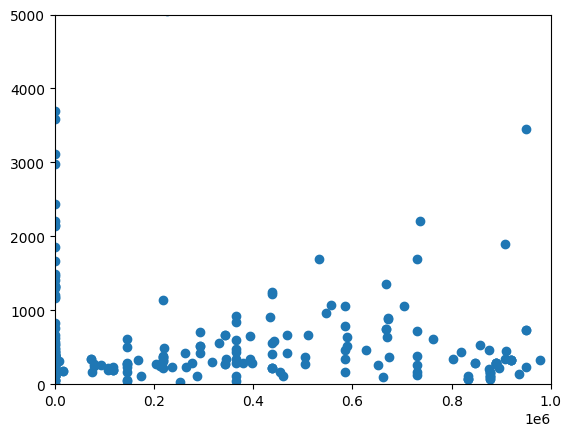

In [507]:
p = plt.scatter(df['Fuel Oil #4 Use (kBtu)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 1000000)
plt.ylim(0, 5000)

(0.0, 5000.0)

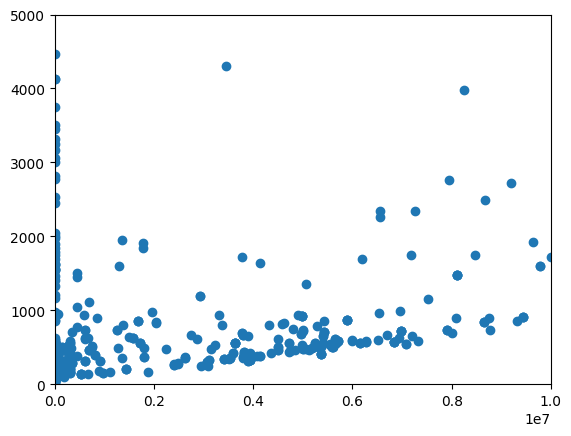

In [508]:
p = plt.scatter(df['Fuel Oil #5 & 6 Use (kBtu)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 10000000)
plt.ylim(0, 5000)

(0.0, 5000.0)

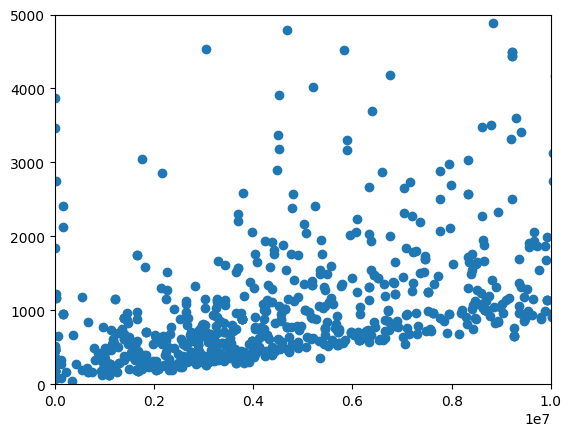

In [509]:
p = plt.scatter(df['District Steam Use (kBtu)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 10000000)
plt.ylim(0, 5000)

(0.0, 50000.0)

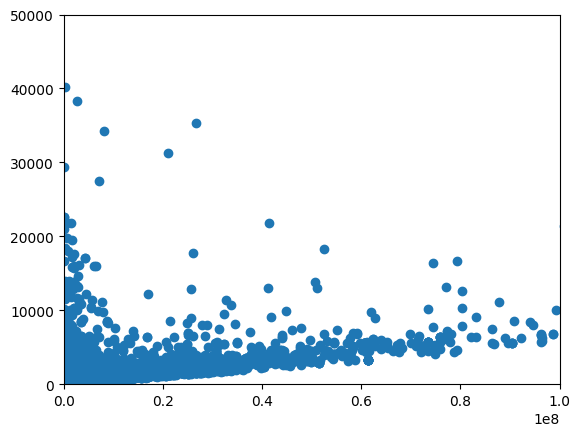

In [510]:
p = plt.scatter(df['Natural Gas Use (kBtu)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 100000000)
plt.ylim(0, 50000)

(0.0, 50000.0)

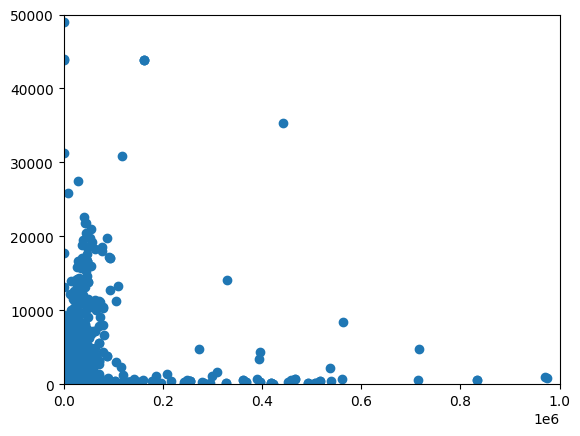

In [511]:
p = plt.scatter(df['Water Use (All Water Sources) (kgal)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 1000000)
plt.ylim(0, 50000)

(0.0, 50000.0)

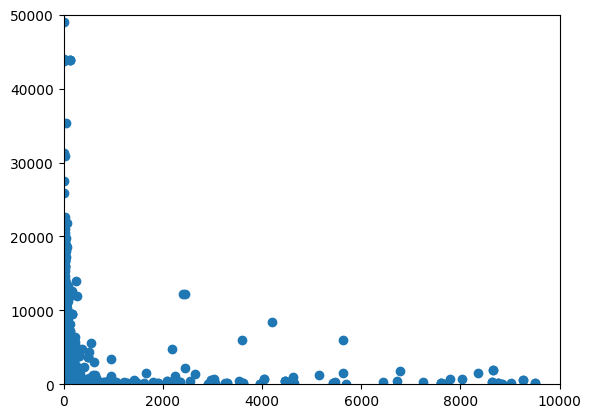

In [512]:
p = plt.scatter(df['Water Use Intensity (All Water Sources) (gal/ft²)'], df['Total GHG Emissions (Metric Tons CO2e)'])
plt.xlim(0, 10000)
plt.ylim(0, 50000)